In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [2]:
# helper
def loadRGBA(path):
    img = cv2.imread(path, -1)
    # if only has rgb, extend it to rgba
    if img.shape[2] == 3:
        rc, gc, bc = cv2.split(img)
        ac = np.ones(bc.shape, dtype=bc.dtype) * 255
        img = cv2.merge((rc, gc, bc, ac))
    return img

## 輸入：
- 一堆圖片 ex:data/sa1/001 ~ data/sa1/119
- 每張圖對應的臉部點座標 ex:data/sa1/001_sol ~ data/sa1/119_sol

In [3]:
# 先選出張嘴的那張圖當作參考臉
REF_FACE_PATH = 'data/sa1/027'
REF_FACE_IMG = loadRGBA(REF_FACE_PATH)
def get_pt_filter():
    global mask
    # mask out none jaw face
    mask = np.zeros(68)
    for i in range(3, 14):
        mask[i] = 1
    for i in range(31, 36):
        mask[i] = 1
    for i in range(48, 68):
        mask[i] = 1
    mask = (mask == 1)
    
    return mask
        
PT_FILTER = get_pt_filter()

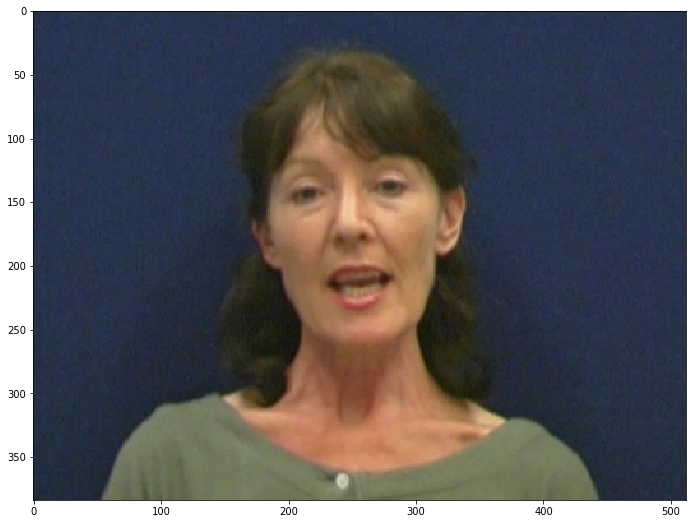

In [4]:
# 畫出參考臉
plt.figure(figsize=(12, 9))
plt.imshow(cv2.cvtColor(REF_FACE_IMG, cv2.COLOR_BGRA2RGBA))
plt.show()

In [5]:
# 回傳一個list [(x1, y1), (x2, y2) ... ]
def get_points(path):
    raw_data = None
    with open(path) as f:
        raw_data = np.array(list(map(lambda x: list(map(float, x.strip('()\n').split(','))), f.readlines()))).flatten()
    
    points = []
    for i in range(len(raw_data)//2):
        if PT_FILTER[i]:
            points.append((int(raw_data[2*i]), int(raw_data[2*i+1])))
    return points

In [6]:
# Check if a point is inside a rectangle
def rect_contains(rect, point):
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

In [7]:
def triangulation(path):
    points = get_points(path+"_sol")

    rect = (0, 0, REF_FACE_IMG.shape[1], REF_FACE_IMG.shape[0])
    subdiv  = cv2.Subdiv2D(rect)
    for p in points:
        subdiv.insert(p)

    tri = []
    for t in subdiv.getTriangleList():
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            pt1idx = points.index(pt1)
            pt2idx = points.index(pt2)
            pt3idx = points.index(pt3)
            tri.append((pt1idx, pt2idx, pt3idx))
    
    return tri

In [8]:
def get_face(path):
    PAD_WIDTH = 5
    points = get_points(path+"_sol")
    
    X_MAX = points[0][0]
    X_MIN = points[0][0]
    Y_MAX = points[0][1]
    Y_MIN = points[0][1]
    for p in points:
        X_MAX = max(X_MAX, p[0])
        X_MIN = min(X_MIN, p[0])
        Y_MAX = max(Y_MAX, p[1])
        Y_MIN = min(Y_MIN, p[1])
        
    X_MAX += PAD_WIDTH
    X_MIN -= PAD_WIDTH
    Y_MAX += PAD_WIDTH
    Y_MIN -= PAD_WIDTH
    
    img = cv2.imread(path)
    img = img[Y_MIN:Y_MAX, X_MIN:X_MAX]
    
    for idx, p in enumerate(points):
        points[idx] = (p[0]-X_MIN, p[1]-Y_MIN)
        
    return points, img

In [9]:
def display_mesh(path, mesh):
    points, img = get_face(path)

    for t in mesh:
        p1, p2, p3 = t
        pt1 = points[p1]
        pt2 = points[p2]
        pt3 = points[p3]
        cv2.line(img, pt1, pt2, (255, 255, 255))
        cv2.line(img, pt2, pt3, (255, 255, 255))
        cv2.line(img, pt3, pt1, (255, 255, 255))
        
    plt.figure(figsize=(12, 9))
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for idx, p in enumerate(points):
        plt.text(p[0], p[1], str(idx),
            bbox={'facecolor':'black', 'alpha':0.7, 'pad':3}, color='white')
    plt.show()

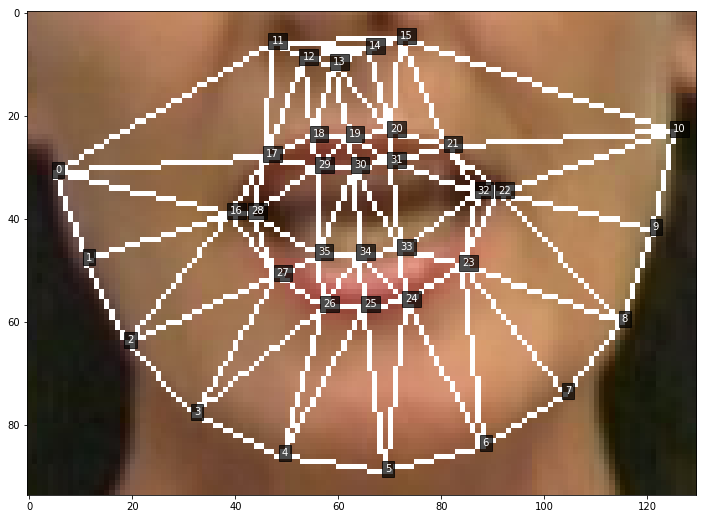

In [10]:
REF_MESH = triangulation(REF_FACE_PATH)
display_mesh(REF_FACE_PATH, REF_MESH)

In [ ]:
def getMask(img, roi_corners):
    mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    ignore_mask_color = (255)
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
    return mask

In [ ]:
def pasteimg(srcimg, dstimg, srcTri, dstTri):
    mask = getMask(srcimg, np.array(srcTri, dtype=np.int32))
    before_area = np.sum(mask)
    
    # warp the mask and srcimg
    M = cv2.getAffineTransform(srcTri, dstTri)
    mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))
    warpped_img = cv2.warpAffine(srcimg, M, (img.shape[1], img.shape[0]))
    
    check = float(np.sum(mask))/float(before_area+1)
    if check < 6:
        for r in range(mask.shape[0]):
            for c in range(mask.shape[1]):
                if mask[r, c] != 0:
                    dstimg[r, c] = warpped_img[r, c]

    return dstimg

In [ ]:
def emptyImg(img):
    return np.zeros(img.shape, dtype=np.uint8)

In [ ]:
def force_warping(path):
    warp_to = OPEN_MOUTH_PATH
    ref_points = get_points(warp_to)
    cur_points = get_points(path)
    src = loadRGBA(path)
    dst = loadRGBA(warp_to)
    
    count = 0
    for t in reference_mesh:
        p1, p2, p3 = t
        srcTri = np.float32([[cur_points[p1], cur_points[p2], cur_points[p3]]])
        dstTri = np.float32([[ref_points[p1], ref_points[p2], ref_points[p3]]])
        dst = pasteimg(src, dst, srcTri, dstTri)
        
        count += 1
    return dst

In [ ]:
display_mesh('data/sa1/002', reference_mesh)

In [ ]:
for i in range(119):
    img = force_warping('data/sa1/'+str(i+1).zfill(3))
    #plt.figure(figsize=(12, 9))
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
    cv2.imwrite('output/test_'+str(i+1).zfill(3)+'.png', img)
    #plt.show()

In [ ]:
def pt_in_cnt(pt, cnt):
    return cv2.pointPolygonTest(cnt, pt, False) == 1.0

In [ ]:
def load_cnt():
    img = loadRGBA(OPEN_MOUTH_PATH)
    points = get_points(OPEN_MOUTH_PATH)
    cnt = []
    for i in range(17):
        cnt.append(points[i])
    for i in range(26, 16, -1):
        cnt.append(points[i])
    cnt = np.array(cnt)

    cnt_mouth = []
    for i in range(60, 68):
        cnt_mouth.append(points[i])
    cnt_mouth = np.array(cnt_mouth)
    
    points_mouth = []
    points_outer = []
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if pt_in_cnt((c, r), cnt):
                if pt_in_cnt((c, r), cnt_mouth):
                    points_mouth.append((c, r))
                else:
                    points_outer.append((c, r))
    return points_mouth, points_outer

In [ ]:
def get_pixels(srcimg, points_mouth, points_outer):
    pixel_mouth = []
    pixel_outer = []
    for p in points_mouth:
        r, c = p
        pixel_mouth.append(srcimg[c, r, :3])
        
    for p in points_outer:
        r, c = p
        pixel_outer.append(srcimg[c, r, :3])  
        
    return np.array(pixel_mouth), np.array(pixel_outer)

In [ ]:
points_mouth, points_outer = load_cnt()
mouth = []
outer = []
for i in range(119):
    img = cv2.imread('output/test_'+str(i+1).zfill(3)+'.png')
    pixel_mouth, pixel_outer = get_pixels(img, points_mouth, points_outer)
    mouth.append(pixel_mouth.flatten())
    outer.append(pixel_outer.flatten())
mouth = np.float64(mouth)
outer = np.float64(outer)

mean_mouth = np.mean(mouth, axis=0)
mouth -= mean_mouth

pca_mouth = PCA(n_components=16)
pca_mouth.fit(mouth)
lowdim_mouth = pca_mouth.transform(mouth)
lowdim_mouth_std = np.std(lowdim_mouth, axis=0)

mean_outer = np.mean(outer, axis=0)
outer -= mean_outer

pca_outer = PCA(n_components=16)
pca_outer.fit(outer)
lowdim_outer = pca_outer.transform(outer)
lowdim_outer_std = np.std(lowdim_outer, axis=0)

In [ ]:
def display_appearance(pts, pixels):
    img = loadRGBA(OPEN_MOUTH_PATH)
    pic = emptyImg(img)
    i = 0
    m = pixels.reshape((-1, 3))
    for p in pts:
        r, c = p
        pic[c, r, :3] = np.int8(m[i])
        i += 1
    plt.figure(figsize=(12, 9))
    plt.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
print(lowdim_mouth_std)
print(lowdim_outer_std)

In [ ]:
alter_dim = 4
test_vector = np.zeros(16)
test_vector[alter_dim] = +lowdim_outer_std[alter_dim] * 3
test_outer = mean_outer + pca_outer.inverse_transform(test_vector)
display_appearance(points_outer, test_outer)

test_vector = np.zeros(16)
test_vector[alter_dim] = -lowdim_outer_std[alter_dim] * 3
test_outer = mean_outer + pca_outer.inverse_transform(test_vector)
display_appearance(points_outer, test_outer)

In [ ]:
alter_dim = 2
test_vector = np.zeros(16)
test_vector[alter_dim] = +lowdim_mouth_std[alter_dim] * 3
test_mouth = mean_mouth + pca_mouth.inverse_transform(test_vector)
display_appearance(points_mouth, test_mouth)

test_vector = np.zeros(16)
test_vector[alter_dim] = -lowdim_mouth_std[alter_dim] * 3
test_mouth = mean_mouth + pca_mouth.inverse_transform(test_vector)
display_appearance(points_mouth, test_mouth)

In [ ]:
all_points = []
for i in range(1, 119+1):
    pts = get_points('data/sa1/'+str(i).zfill(3))
    pts = np.array(pts)
    all_points.append(pts.flatten())
all_points = np.float64(all_points)

mean_shape = np.mean(all_points, axis=0)
all_points -= mean_shape

pca_shape = PCA(n_components=16)
pca_shape.fit(all_points)
lowdim_shape = pca_shape.transform(all_points)
lowdim_shape_std = np.std(lowdim_shape, axis=0)

In [ ]:
Wp = np.sqrt(np.sum(lowdim_mouth_std**2) / np.sum(lowdim_shape_std**2))
Wlambda = np.sqrt(np.sum(lowdim_mouth_std**2) / np.sum(lowdim_outer_std**2))
b = np.column_stack((Wp * lowdim_shape, Wlambda * lowdim_outer, lowdim_mouth))

pca_b = PCA(n_components=16)
pca_b.fit(b)
lowdim_b = pca_b.transform(b)
lowdim_b_std = np.std(lowdim_b, axis=0)

In [ ]:
def warp_to(ref_points, src):
    cur_points = get_points(OPEN_MOUTH_PATH)
    dst = emptyImg(src)
    
    for t in reference_mesh:
        p1, p2, p3 = t
        srcTri = np.float32([[cur_points[p1], cur_points[p2], cur_points[p3]]])
        dstTri = np.float32([[ref_points[p1], ref_points[p2], ref_points[p3]]])
        dst = pasteimg(src, dst, srcTri, dstTri)
        
    return dst

In [ ]:
def display_combined(outer_pts, mouth_pts, test_vector):
    test_b = pca_b.inverse_transform(test_vector)
    test_shape = mean_shape + pca_shape.inverse_transform(test_b[:16] / Wp)
    test_outer = mean_outer + pca_outer.inverse_transform(test_b[16:32] / Wlambda)
    test_mouth = mean_mouth + pca_mouth.inverse_transform(test_b[32:])
    
    img = loadRGBA(OPEN_MOUTH_PATH)
    pic = emptyImg(img)
    
    i = 0
    m = test_outer.reshape((-1, 3))
    for p in outer_pts:
        r, c = p
        pic[c, r, :3] = np.int8(m[i])
        i += 1
    
    i = 0
    m = test_mouth.reshape((-1, 3))
    for p in mouth_pts:
        r, c = p
        pic[c, r, :3] = np.int8(m[i])
        i += 1
    
    points = []
    for i in test_shape.reshape(-1, 2):
        points.append((i[0], i[1]))
    
    dst = warp_to(points, pic)
    plt.figure(figsize=(12, 9))
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
fake_vector = np.zeros(16)
fake_vector[0] = -lowdim_b_std[0] * 3
display_combined(points_outer, points_mouth, fake_vector)

In [ ]:
fake_vector = np.zeros(16)
fake_vector[0] = +lowdim_b_std[0] * 3
display_combined(points_outer, points_mouth, fake_vector)